# Proyecto Inteligencia Artificial

### Jose Antonio Valero

El objetivo del proyecto es analizar un dataset acerca de créditos aprobados por un banco a distintos individuos y crear un modelo que sea capaz de predecir con precisión si se otorgaria el crédito o no.

Dataset extraido de Kaggle (https://www.kaggle.com/datasets/samuelcortinhas/credit-card-approval-clean-data)
Este data-set está ya limpio, aunque realizaremos varias modificaciones sobre el mismo.
El data-set original se puede encontrar en: (https://archive.ics.uci.edu/ml/datasets/Credit+Approval?msclkid=200008bdc4a311ec9f500a3245a2bfb1)


In [25]:
#Imports

# Análisis de datos
import pandas as pd
import numpy as np
import random as rnd

# Visualización
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

from pylab import rcParams
from collections import Counter

In [26]:
#Empezamos cargando el dataset

df = pd.read_csv(r"clean_dataset.csv",sep=',')
print(df.columns.values)

['Gender' 'Age' 'Debt' 'Married' 'BankCustomer' 'Industry' 'Ethnicity'
 'YearsEmployed' 'PriorDefault' 'Employed' 'CreditScore' 'DriversLicense'
 'Citizen' 'ZipCode' 'Income' 'Approved']


- Gender--> Sexo
- Age--> Edad
- Debt--> Deuda pendiente
- Married--> Si está casado o no
- BankCustomer--> Si el individuo es cliente del banco
- Industry--> Sector en el que trabaja el individuo
- Ethnicity--> Etnia del individuo
- YearsEmployed--> Cuantos años lleva trabajando en su actual empresa
- PriorDefault--> Si el individuo ha fallado en los pagos de un préstamos previamente
- Employed--> Si el individuo trabaja actualmente
- CreditScore--> Puntuación de crédito
- DriverLicense--> Si el individuo tiene carnet de conducir
- Citizen--> Si el individuo es ciudadano por nacimiento, por otros medios o temporal
- ZipCode--> Código postal
- Income--> Ingresos (Escalados)
- Aproved--> Si le han aprobado el crédito o no

In [27]:
#comprobamos los datos

print(df.head())
print("_"*60)

df.info()

   Gender    Age   Debt  Married  BankCustomer     Industry Ethnicity  \
0       1  30.83  0.000        1             1  Industrials     White   
1       0  58.67  4.460        1             1    Materials     Black   
2       0  24.50  0.500        1             1    Materials     Black   
3       1  27.83  1.540        1             1  Industrials     White   
4       1  20.17  5.625        1             1  Industrials     White   

   YearsEmployed  PriorDefault  Employed  CreditScore  DriversLicense  \
0           1.25             1         1            1               0   
1           3.04             1         1            6               0   
2           1.50             1         0            0               0   
3           3.75             1         1            5               1   
4           1.71             1         0            0               0   

        Citizen  ZipCode  Income  Approved  
0       ByBirth      202       0         1  
1       ByBirth       43     560

Como podemos observar en el apartado anterior no hay valores nulos.
Pero observando el dataset, podemos realizar varios cambios:
1- Eliminar la columna DriversLicense, ya que nos resulta irrelevante.
2- Transformar las características categóricas a cuantitativas para facilitar el trabajo al modelo
    Estas son: Industry,Ethnicity y Citizen
3- Agrupar en tramos: 
    Age, Debt, YearsEmployed, Income, ZipCode

In [28]:
#Eliminamos la columna DriversLicense

df.drop("DriversLicense", axis=1, inplace=True) 
#Axis 1 hace referencia a la columna. Inplace quiere decir que se haga en el propio dataframe
df.head()

,Gender,Age,Debt,Married,BankCustomer,Industry,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,Citizen,ZipCode,Income,Approved
0,1,30.83,0.000,1,1,Industrials,White,1.25,1,1,1,ByBirth,202,0,1
1,0,58.67,4.460,1,1,Materials,Black,3.04,1,1,6,ByBirth,43,560,1
2,0,24.50,0.500,1,1,Materials,Black,1.50,1,0,0,ByBirth,280,824,1
3,1,27.83,1.540,1,1,Industrials,White,3.75,1,1,5,ByBirth,100,3,1
4,1,20.17,5.625,1,1,Industrials,White,1.71,1,0,0,ByOtherMeans,120,0,1


In [29]:
#Transformar las características categóricas:

df.describe(include=['O']) # Este include es para mostrar las variable categóricas

,Industry,Ethnicity,Citizen
count,690,690,690
unique,14,5,3
top,Energy,White,ByBirth
freq,146,408,625


Se puede observar que para Industria hay 14 valores únicos, para Etnia 5 y para Ciudadania 3.
Vamos a profundizar un poco mas y vamos a ver cuales son estos valores únicos.

<AxesSubplot:>

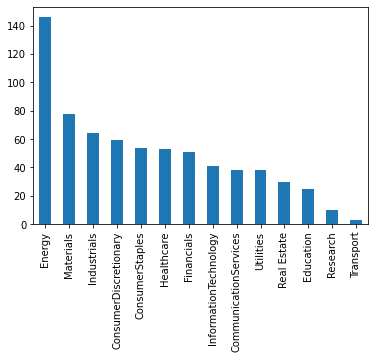

In [30]:
df['Industry'].value_counts().plot(kind='bar')

<AxesSubplot:>

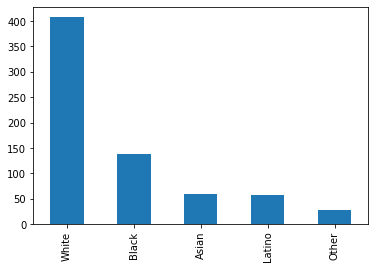

In [31]:
df['Ethnicity'].value_counts().plot(kind='bar')

<AxesSubplot:>

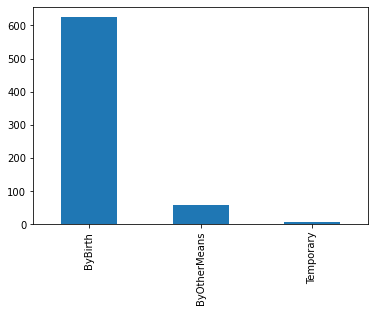

In [32]:
df['Citizen'].value_counts().plot(kind='bar')

In [33]:
#Vamos a convertir dichas características categóricas en númericas

le = preprocessing.LabelEncoder()
df['Industry'] = le.fit_transform(df.Industry.values)
df['Ethnicity'] = le.fit_transform(df.Ethnicity.values)
df['Citizen'] = le.fit_transform(df.Citizen.values)
print(df.head())


   Gender    Age   Debt  Married  BankCustomer  Industry  Ethnicity  \
0       1  30.83  0.000        1             1         7          4   
1       0  58.67  4.460        1             1         9          1   
2       0  24.50  0.500        1             1         9          1   
3       1  27.83  1.540        1             1         7          4   
4       1  20.17  5.625        1             1         7          4   

   YearsEmployed  PriorDefault  Employed  CreditScore  Citizen  ZipCode  \
0           1.25             1         1            1        0      202   
1           3.04             1         1            6        0       43   
2           1.50             1         0            0        0      280   
3           3.75             1         1            5        0      100   
4           1.71             1         0            0        1      120   

   Income  Approved  
0       0         1  
1     560         1  
2     824         1  
3       3         1  
4       0   

   Gender  Age   Debt  Married  BankCustomer  Industry  Ethnicity  \
0       1  3.0  0.000        1             1         7          4   
1       0  6.0  4.460        1             1         9          1   
2       0  2.0  0.500        1             1         9          1   
3       1  2.0  1.540        1             1         7          4   
4       1  1.0  5.625        1             1         7          4   

   YearsEmployed  PriorDefault  Employed  CreditScore  Citizen  ZipCode  \
0           1.25             1         1            1        0      202   
1           3.04             1         1            6        0       43   
2           1.50             1         0            0        0      280   
3           3.75             1         1            5        0      100   
4           1.71             1         0            0        1      120   

   Income  Approved  
0       0         1  
1     560         1  
2     824         1  
3       3         1  
4       0         1  


<AxesSubplot:>

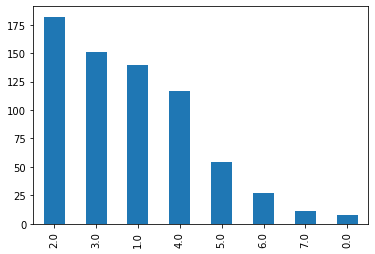

In [34]:
#Comenzamos la agrupación en tramos
#Edad

df.loc[df['Age'] <= 16, 'Age'] = 0
df.loc[(df['Age'] > 16) & (df['Age'] <= 22), 'Age'] = 1
df.loc[(df['Age'] > 22) & (df['Age'] <= 28), 'Age'] = 2
df.loc[(df['Age'] > 28) & (df['Age'] <= 35), 'Age'] = 3
df.loc[(df['Age'] > 35) & (df['Age'] <= 45), 'Age'] = 4
df.loc[(df['Age'] > 45) & (df['Age'] <= 55), 'Age'] = 5
df.loc[(df['Age'] > 55) & (df['Age'] <= 65), 'Age'] = 6
df.loc[(df['Age'] > 65), 'Age'] = 7

print(df.head())
df['Age'].value_counts().plot(kind='bar')


<AxesSubplot:>

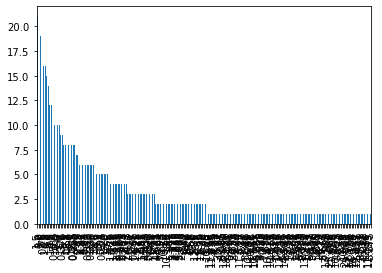

In [35]:
#Debt
df['Debt'].value_counts().plot(kind='bar')
#Observamos los datos originales para hacernois una idea de como agrupar los datos

,Gender,Age,Debt,Married,BankCustomer,Industry,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,Citizen,ZipCode,Income,Approved
0,1,3.0,0.0,1,1,7,4,1.25,1,1,1,0,202,0,1
1,0,6.0,1.0,1,1,9,1,3.04,1,1,6,0,43,560,1
2,0,2.0,0.0,1,1,9,1,1.50,1,0,0,0,280,824,1
3,1,2.0,0.0,1,1,7,4,3.75,1,1,5,0,100,3,1
4,1,1.0,2.0,1,1,7,4,1.71,1,0,0,1,120,0,1


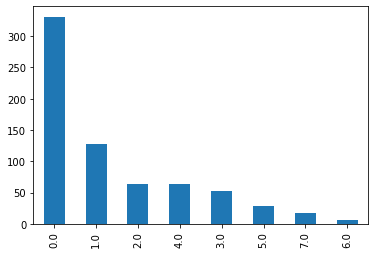

In [36]:
#En base a la gráfica anterior, decido agruparlos en tramos de 2.5
df.loc[(df['Debt'] >=0) & (df['Debt'] <= 2.5), 'Debt'] = 0
df.loc[(df['Debt'] >2.5) & (df['Debt'] <= 5), 'Debt'] = 1
df.loc[(df['Debt'] >5) & (df['Debt'] <= 7.5), 'Debt'] = 2
df.loc[(df['Debt'] >7.5) & (df['Debt'] <= 10), 'Debt'] = 3
df.loc[(df['Debt'] >10) & (df['Debt'] <= 12.5), 'Debt'] = 4
df.loc[(df['Debt'] >12.5) & (df['Debt'] <= 15), 'Debt'] = 5
df.loc[(df['Debt'] >15) & (df['Debt'] <= 17.5), 'Debt'] = 6
df.loc[(df['Debt'] > 17.5), 'Debt'] = 7
#comprobamos el resultado

df['Debt'].value_counts().plot(kind='bar')
df.head()


In [37]:
#Para years employed simplemente vamos a truncar el valor

df["YearsEmployed"] = df["YearsEmployed"].astype(int)
df.head()

,Gender,Age,Debt,Married,BankCustomer,Industry,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,Citizen,ZipCode,Income,Approved
0,1,3.0,0.0,1,1,7,4,1,1,1,1,0,202,0,1
1,0,6.0,1.0,1,1,9,1,3,1,1,6,0,43,560,1
2,0,2.0,0.0,1,1,9,1,1,1,0,0,0,280,824,1
3,1,2.0,0.0,1,1,7,4,3,1,1,5,0,100,3,1
4,1,1.0,2.0,1,1,7,4,1,1,0,0,1,120,0,1


count       690.000000
mean       1017.385507
std        5210.102598
min           0.000000
25%           0.000000
50%           5.000000
75%         395.500000
max      100000.000000
Name: Income, dtype: float64


,Gender,Age,Debt,Married,BankCustomer,Industry,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,Citizen,ZipCode,Income,Approved
0,1,3.0,0.0,1,1,7,4,1,1,1,1,0,202,0,1
1,0,6.0,1.0,1,1,9,1,3,1,1,6,0,43,3,1
2,0,2.0,0.0,1,1,9,1,1,1,0,0,0,280,4,1
3,1,2.0,0.0,1,1,7,4,3,1,1,5,0,100,1,1
4,1,1.0,2.0,1,1,7,4,1,1,0,0,1,120,0,1


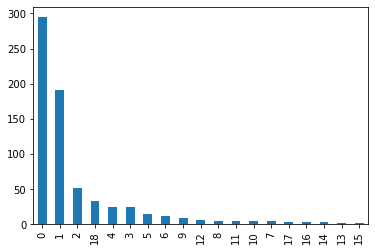

In [38]:
#Income
print(df["Income"].describe())

df.loc[(df['Income'] ==0) , 'Income'] = 0
df.loc[(df['Income'] > 0) & (df['Income'] <= 250), 'Income'] = 1
df.loc[(df['Income'] > 250) & (df['Income'] <= 500), 'Income'] = 2
df.loc[(df['Income'] > 500) & (df['Income'] <= 750), 'Income'] = 3
df.loc[(df['Income'] > 750) & (df['Income'] <= 1000), 'Income'] = 4
df.loc[(df['Income'] > 1000) & (df['Income'] <= 1250), 'Income'] = 5
df.loc[(df['Income'] > 1250) & (df['Income'] <= 1500), 'Income'] = 6
df.loc[(df['Income'] > 1500) & (df['Income'] <= 1750), 'Income'] = 7
df.loc[(df['Income'] > 1750) & (df['Income'] <= 2000), 'Income'] = 8
df.loc[(df['Income'] > 2000) & (df['Income'] <= 2250), 'Income'] = 9
df.loc[(df['Income'] > 2250) & (df['Income'] <= 2500), 'Income'] = 10
df.loc[(df['Income'] > 2500) & (df['Income'] <= 2750), 'Income'] = 11
df.loc[(df['Income'] > 2750) & (df['Income'] <= 3000), 'Income'] = 12
df.loc[(df['Income'] > 3000) & (df['Income'] <= 3250), 'Income'] = 13
df.loc[(df['Income'] > 3250) & (df['Income'] <= 3500), 'Income'] = 14
df.loc[(df['Income'] > 3500) & (df['Income'] <= 3750), 'Income'] = 15
df.loc[(df['Income'] > 3750) & (df['Income'] <= 4000), 'Income'] = 16
df.loc[(df['Income'] > 4000) & (df['Income'] <= 4250), 'Income'] = 17
df.loc[(df['Income'] > 3000) , 'Income'] = 18

df['Income'].value_counts().plot(kind='bar')
df.head()


In [39]:
#Para agrupar los ZipCodes, simplemente nos quedamos con el primer dígito

df['ZipCode'] = df.ZipCode.astype(str).str[:1]
df["ZipCode"] = df["ZipCode"].astype(int)
print(df.head())

   Gender  Age  Debt  Married  BankCustomer  Industry  Ethnicity  \
0       1  3.0   0.0        1             1         7          4   
1       0  6.0   1.0        1             1         9          1   
2       0  2.0   0.0        1             1         9          1   
3       1  2.0   0.0        1             1         7          4   
4       1  1.0   2.0        1             1         7          4   

   YearsEmployed  PriorDefault  Employed  CreditScore  Citizen  ZipCode  \
0              1             1         1            1        0        2   
1              3             1         1            6        0        4   
2              1             1         0            0        0        2   
3              3             1         1            5        0        1   
4              1             1         0            0        1        1   

   Income  Approved  
0       0         1  
1       3         1  
2       4         1  
3       1         1  
4       0         1  


Una vez limpiado y ajustado el dataset, podemos pasar a las predicciones

In [40]:
#Dividimos el dataset en train y test y dividimos 80/20 el train/test


x = df[["Gender", "Age", "Debt", "Married", "BankCustomer", "Industry", "Ethnicity", "YearsEmployed", "PriorDefault", "Employed", "CreditScore", "Citizen", "ZipCode", "Income"]]
y = df["Approved"]



X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state=20)

print("Hay {} registros en el set de train y {} registros en el set de test".format(X_train.shape[0], X_test.shape[0]))

Hay 552 registros en el set de train y 138 registros en el set de test


In [41]:
#Regresion logistica

# Definimos el modelo, en este caso un modelo de regresión logisitca
model = LogisticRegression(max_iter=200)

# Entrenamos el modelo
model.fit(X_train, y_train)

# Comprobamos las metricas tras el entrenamiento
print("Train Accuracy: {:.3f}".format(model.score(X_train, y_train)))
print("Test Accuracy (pre-predicción): {:.3f}".format(model.score(X_test, y_test)))

Train Accuracy: 0.862
Test Accuracy (pre-predicción): 0.870


In [42]:
#KNN
n_neighbors = 7

knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))


Accuracy of K-NN classifier on training set: 0.80
Accuracy of K-NN classifier on test set: 0.73


In [47]:
#SVM
modelo = SVC(gamma='auto')
modelo.fit(X_train,y_train)
predicciones = modelo.predict(X_test)
print(classification_report(y_test, predicciones))



              precision    recall  f1-score   support

           0       0.76      0.88      0.81        74
           1       0.83      0.67      0.74        64

    accuracy                           0.78       138
   macro avg       0.79      0.78      0.78       138
weighted avg       0.79      0.78      0.78       138



In [44]:
#RandomForest
model = RandomForestClassifier(n_estimators=100, class_weight="balanced",
                               max_features = 'sqrt', verbose=2, max_depth=6,
                               oob_score=True, random_state=50)
# a entrenar
model.fit(X_train, y_train)

pred_y = model.predict(X_test)

# Calculate roc auc
roc_value = roc_auc_score(y_test, pred_y)
print(roc_value)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Recopilación de resultados:

-Random forest 86.4%
-SVM           78%
-KNN           73%
-Reg.Log       87%

A continuación vamos a crear varias visualizaciones para entender mejor los datos

<AxesSubplot:>

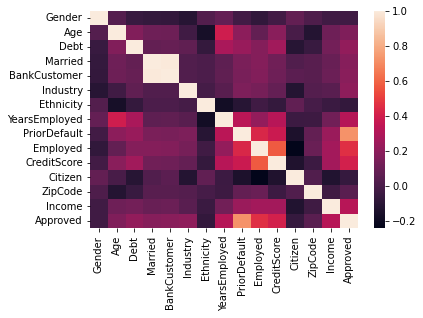

In [45]:
#Creamos un heatmap, en el que se muestran las correlaciones entre datos.
sns.heatmap(df.corr())

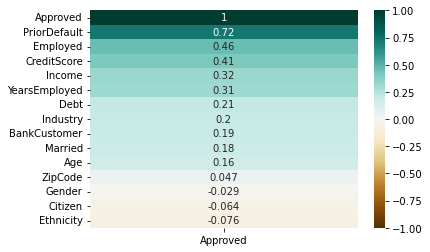

In [46]:
#Correlación en relación a la variable target (Approved)
heatmap = sns.heatmap(df.corr()[['Approved']].sort_values(by='Approved', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')

Se puede observar que hay tres factores que influyen en gran medida para que un préstamo sea concedido:
-PriorDefault: es decir, si el individuo ha fallado a la hora de devolver el dinero en ocasiones anteriores es ams probable que no le concedan un préstamo
-Employed: Si el individuo tiene empleo, es mas probable que le concedan un crédito
-Credit Score: Cuanto mayor sea el credit score del individuo mas probabilidad de que se lo concedan